* How to split data? Upsample or not?
* How to deal with 62 channels? https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn 
import torch.nn.functional as F
from scipy.io import loadmat
import os
from os import listdir
import pandas as pd
from skimage import io
from PIL import Image
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pickle

from utils import *

In [2]:
CH = 'all'
device = torch.device('cuda')
val_dates = ['180327','180329']
test_dates = ['180330','180331']
bad_dates = ['180326', '180328', '171019', '180715', '180716', '180717']
load_path = '/home/bijanadmin/Desktop/Goose_data/data_Goose_1st_2/'
save_path = '/mnt/pesaranlab/People/Capstone_students/Yue/model/model_Goose_1st_2_upsample'

In [3]:
train_files, val_files, test_files = create_files(load_path, val_dates, test_dates, bad_dates)

In [4]:
import operator
train_files = sorted(train_files, key=operator.itemgetter(3, 4, 5))
val_files = sorted(val_files, key=operator.itemgetter(3, 4, 5))
test_files = sorted(test_files, key=operator.itemgetter(3, 4, 5))

In [5]:
class SpectrogramDatasetRNN(Dataset):
    def __init__(self, files, load_path, CH=None):
        self.CH = CH
        self.files = files
        self.load_path = load_path
  
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        f, label, mvmt_type, date, rec, time = self.files[idx]
        spec = torch.from_numpy(np.load(self.load_path+mvmt_type+'/'+f))
        if self.CH is not None:
            return spec[self.CH,:,:], torch.Tensor([label]), date, rec, time # Remember to use batch_fist=True
        else:
            return spec.mean(0), torch.Tensor([label]), date, rec, time

In [6]:
train_dataset = SpectrogramDatasetRNN(files=train_files, load_path=load_path, CH=None)
valid_dataset = SpectrogramDatasetRNN(files=val_files, load_path=load_path, CH=None)
test_dataset = SpectrogramDatasetRNN(files=test_files, load_path=load_path, CH=None)

train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle = False)
val_loader = DataLoader(dataset=valid_dataset, batch_size=128, shuffle = False)
test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle = False)

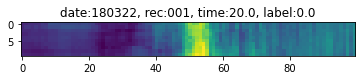

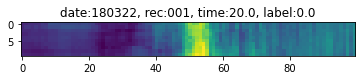

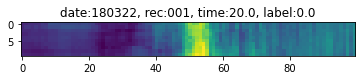

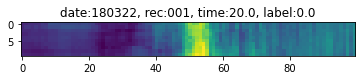

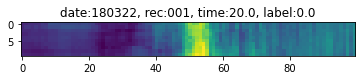

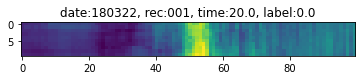

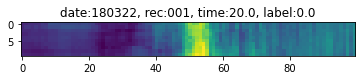

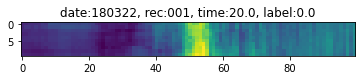

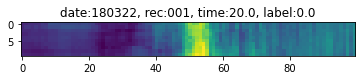

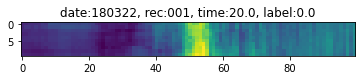

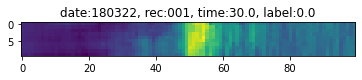

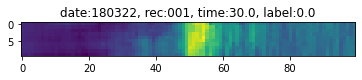

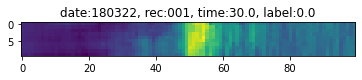

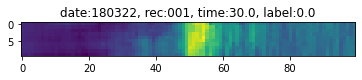

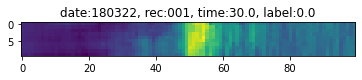

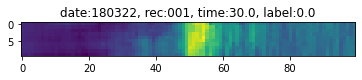

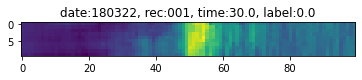

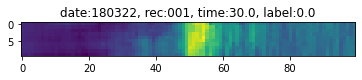

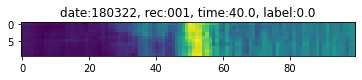

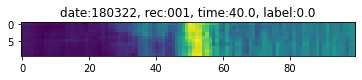

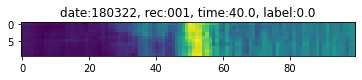

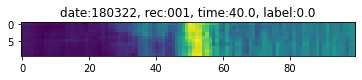

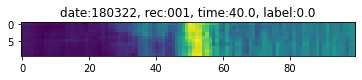

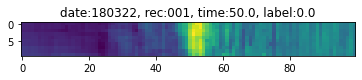

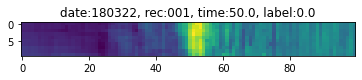

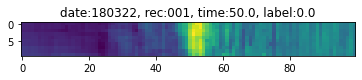

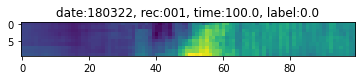

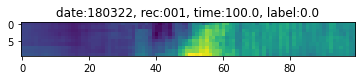

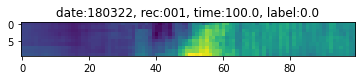

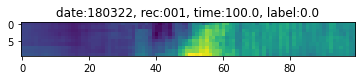

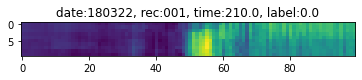

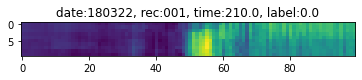

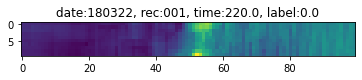

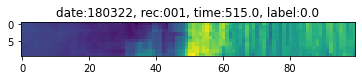

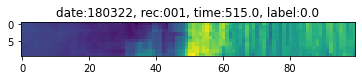

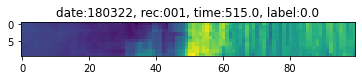

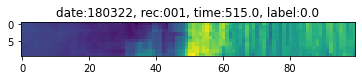

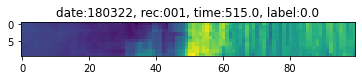

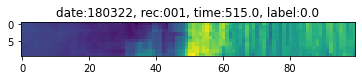

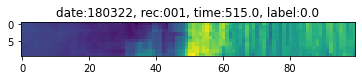

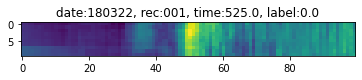

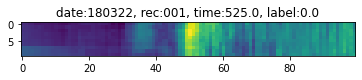

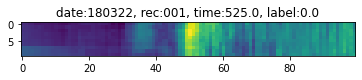

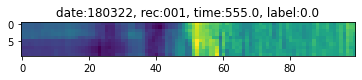

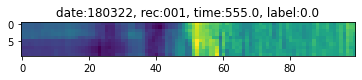

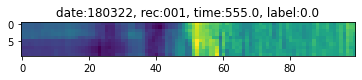

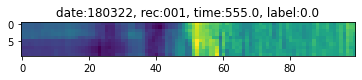

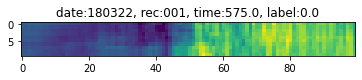

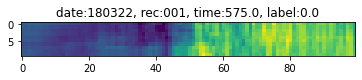

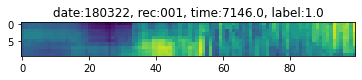

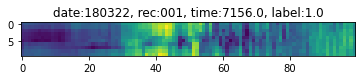

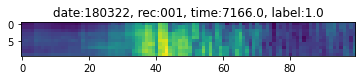

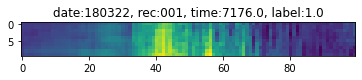

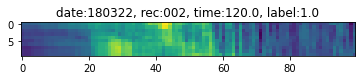

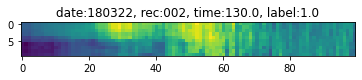

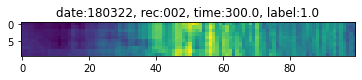

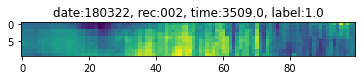

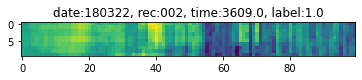

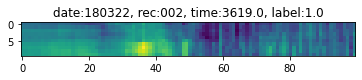

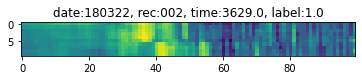

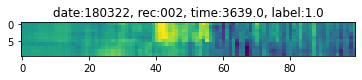

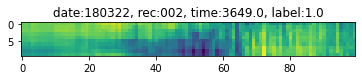

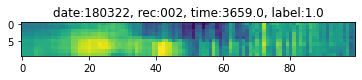

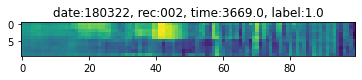

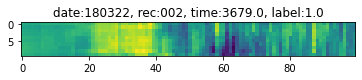

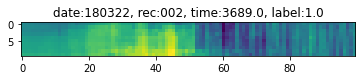

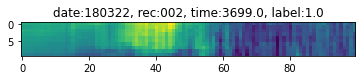

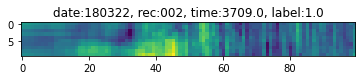

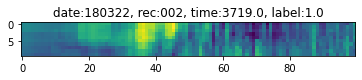

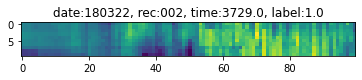

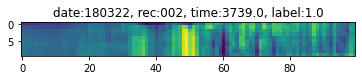

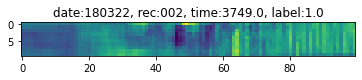

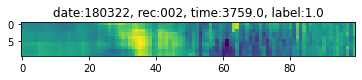

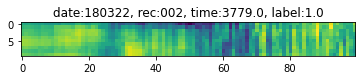

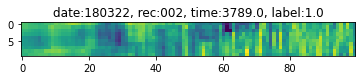

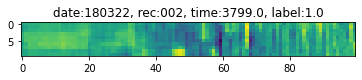

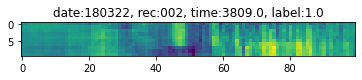

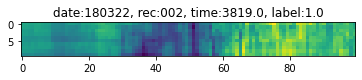

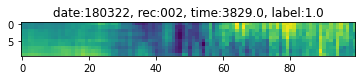

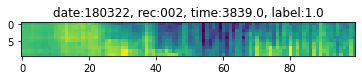

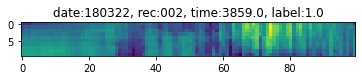

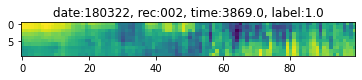

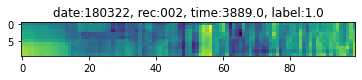

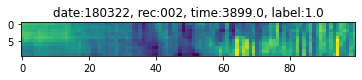

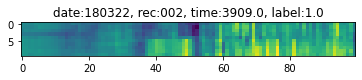

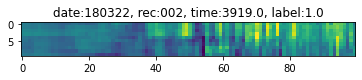

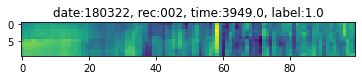

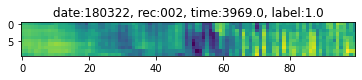

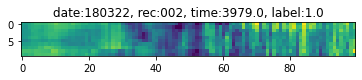

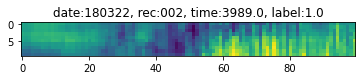

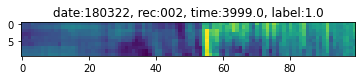

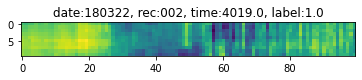

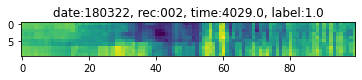

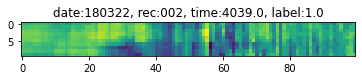

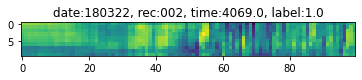

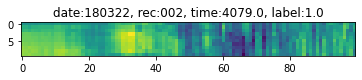

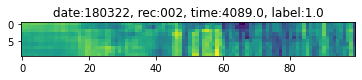

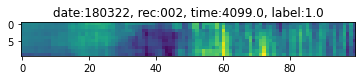

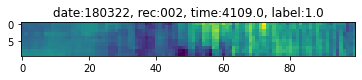

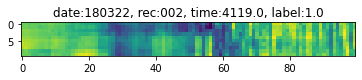

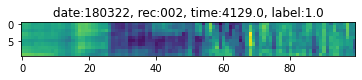

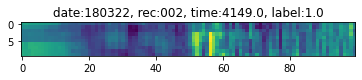

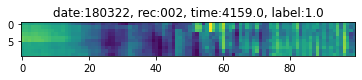

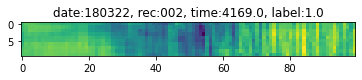

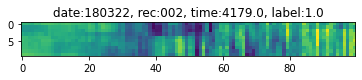

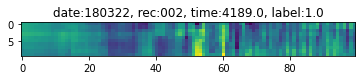

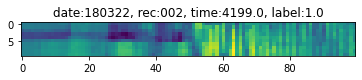

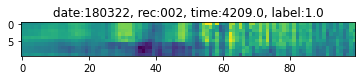

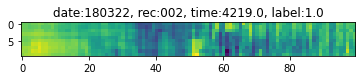

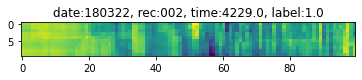

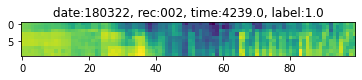

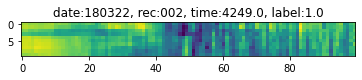

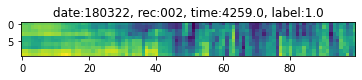

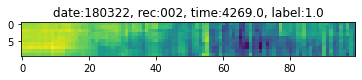

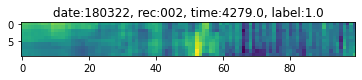

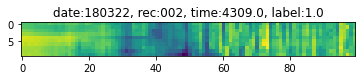

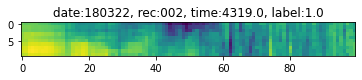

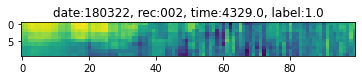

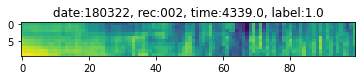

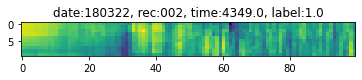

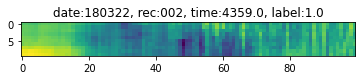

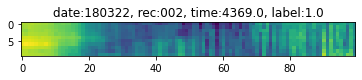

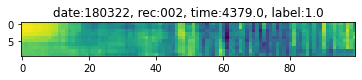

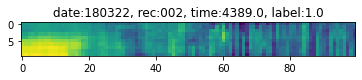

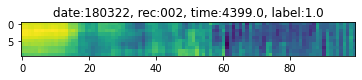

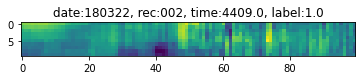

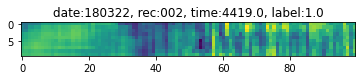

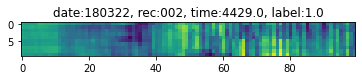

In [30]:
for batch_idx, (data, label, date, rec, time) in enumerate(train_loader): # Double check input
    for i in range(len(data)):
        plt.imshow(data[i])
        plt.title('date:{}, rec:{}, time:{}, label:{}'.format(date[i], rec[i], time[i], label[i].numpy()[0]))
        plt.show()
    break

In [7]:
class LSTM(nn.Module):
    def __init__(self, input_size=100, hidden_size=100, output_size=1, batch_size=128):
        super().__init__()
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size*10, output_size) # hard code
    
    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq)
        predictions = self.linear(lstm_out.reshape(lstm_out.shape[0], -1))
        return predictions

In [8]:
learning_rate = 0.001
num_epochs = 51
alpha = 0
model_type = 'LSTM'
loss_type = 'bce'
reg_type = 'none'

model = LSTM().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

0
Train loss for epoch 0: 0.6157428622245789
Val loss for epoch 0: 0.43536677956581116
2
Train loss for epoch 2: 0.4513148367404938
Val loss for epoch 2: 0.4089546799659729
3
Train loss for epoch 3: 0.40880534052848816
Val loss for epoch 3: 0.3753540813922882
4
Train loss for epoch 4: 0.3833303451538086
Val loss for epoch 4: 0.3418770432472229
5
Train loss for epoch 5: 0.36142075061798096
Val loss for epoch 5: 0.32653412222862244
6
Train loss for epoch 6: 0.3445604145526886
Val loss for epoch 6: 0.31131812930107117
7
Train loss for epoch 7: 0.3311123549938202
Val loss for epoch 7: 0.3010195791721344
8
Train loss for epoch 8: 0.31706327199935913
Val loss for epoch 8: 0.2898913621902466
9
Train loss for epoch 9: 0.3036169111728668
Val loss for epoch 9: 0.2892070412635803
10
Train loss for epoch 10: 0.2921229898929596
Val loss for epoch 10: 0.2857949435710907
11
Train loss for epoch 11: 0.2792997360229492
Val loss for epoch 11: 0.2834681272506714
12
Train loss for epoch 12: 0.266969114542

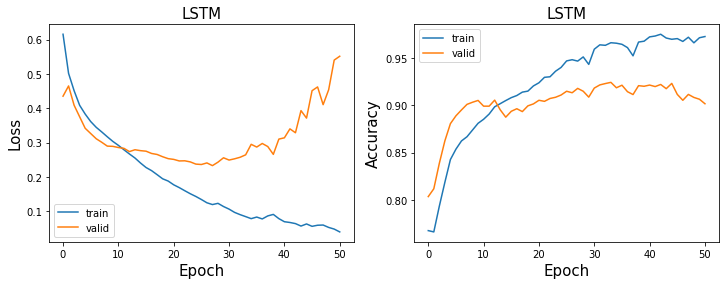

In [9]:
best_epoch, min_val_loss = tuning(train_loader, val_loader, model, optimizer, device, num_epochs, alpha, model_type, loss_type, reg_type, CH, save_path)

In [10]:
model = LSTM().to(device)
model.load_state_dict(torch.load('{}/{}_CH{}_LOSS{}_REG{}{}_EPOCH{}_REDUCEsum.pt'.format(save_path, model_type, CH, loss_type, reg_type, alpha, best_epoch)))

<All keys matched successfully>

test loss:0.3035241961479187, test accuracy:0.9020643302928468, test percentage postive:0.7385181784629822


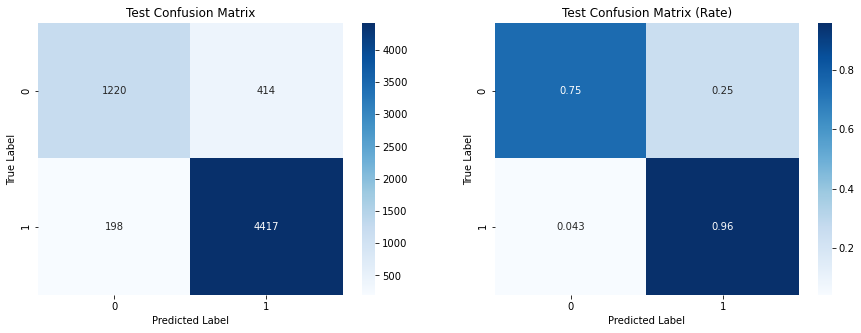

In [11]:
test_loss, test_acc, test_preds, test_preds_probs, test_labels, _, _, _, case_wrong_test = evaluate(model, optimizer, test_loader, alpha=alpha, model_type=model_type, loss_type=loss_type, reg_type=reg_type, collect_result=True, device=device)
print('test loss:{}, test accuracy:{}, test percentage postive:{}'.format(test_loss, test_acc, np.mean(np.concatenate(test_labels))))
plot_confusion(test_preds, test_labels)

val loss:0.23306745290756226, val accuracy:0.9177275620623806, val percentage postive:0.7856460809707642


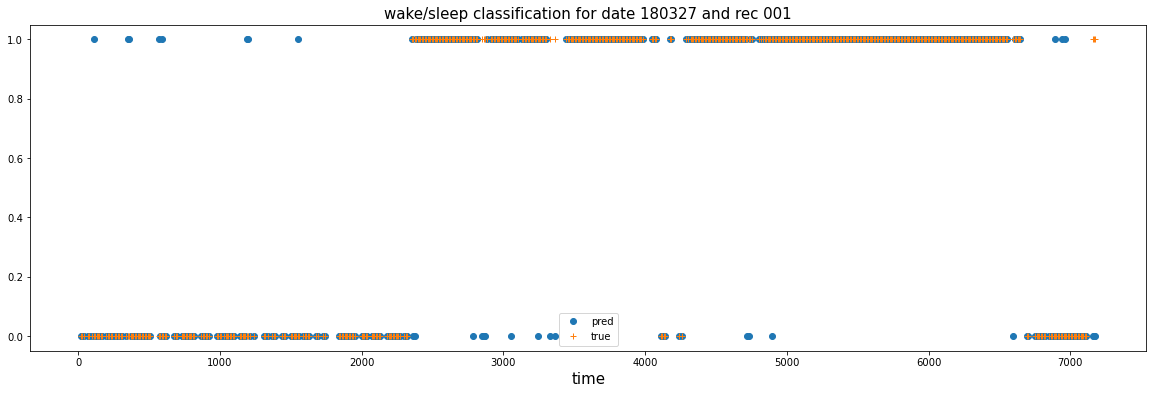

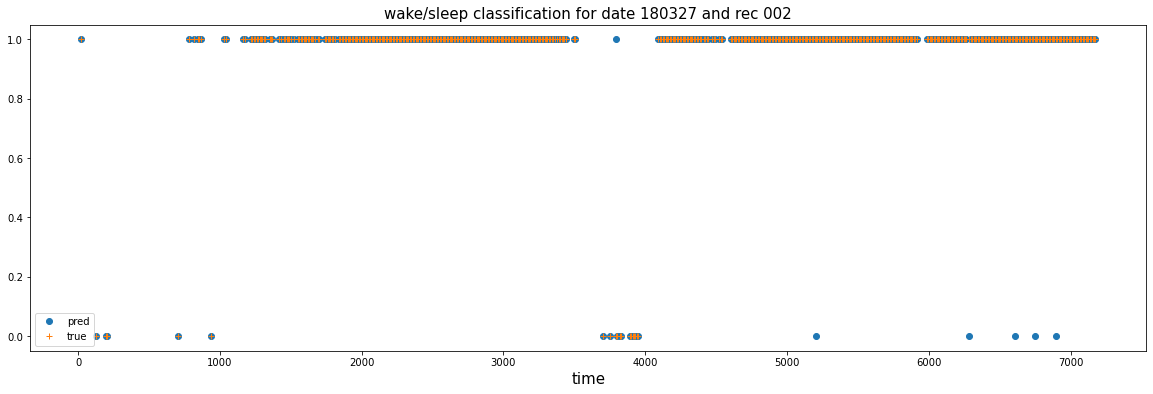

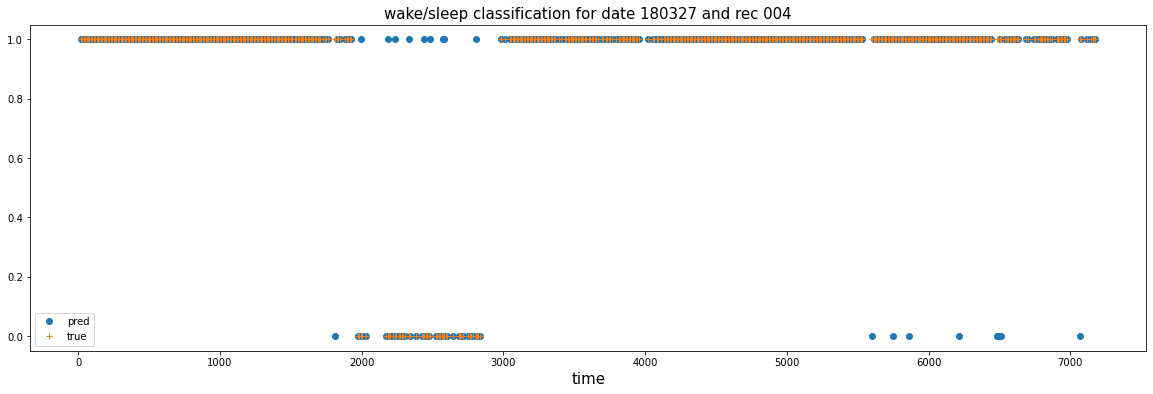

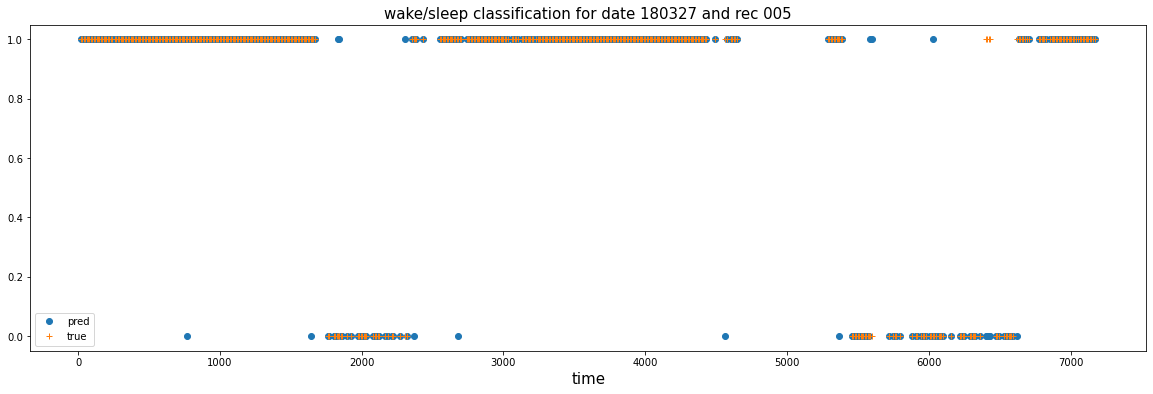

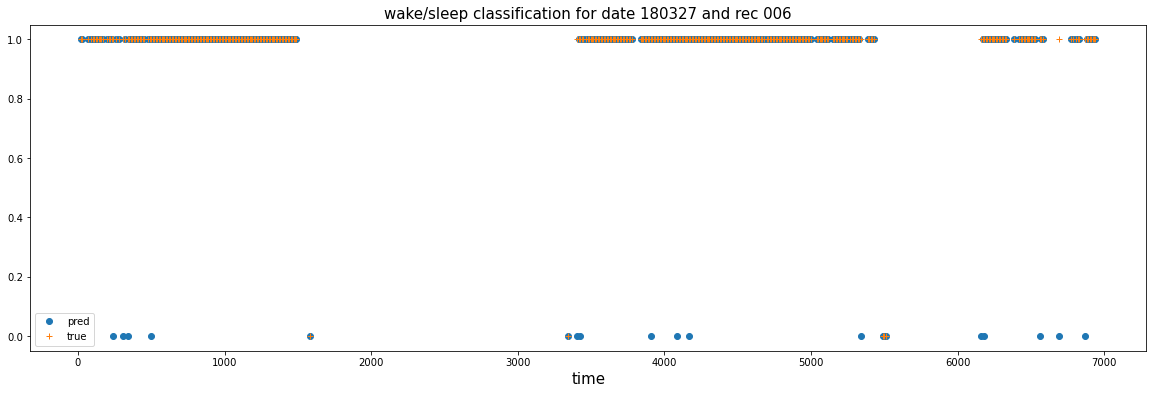

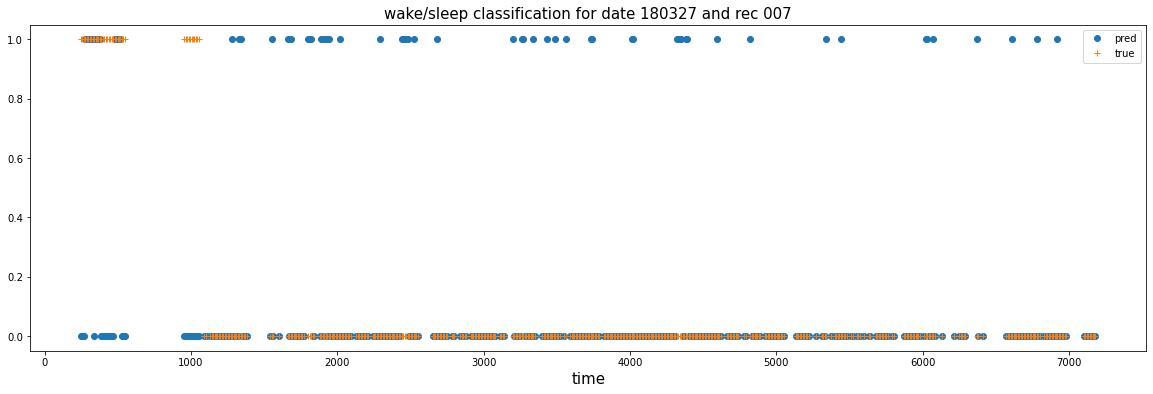

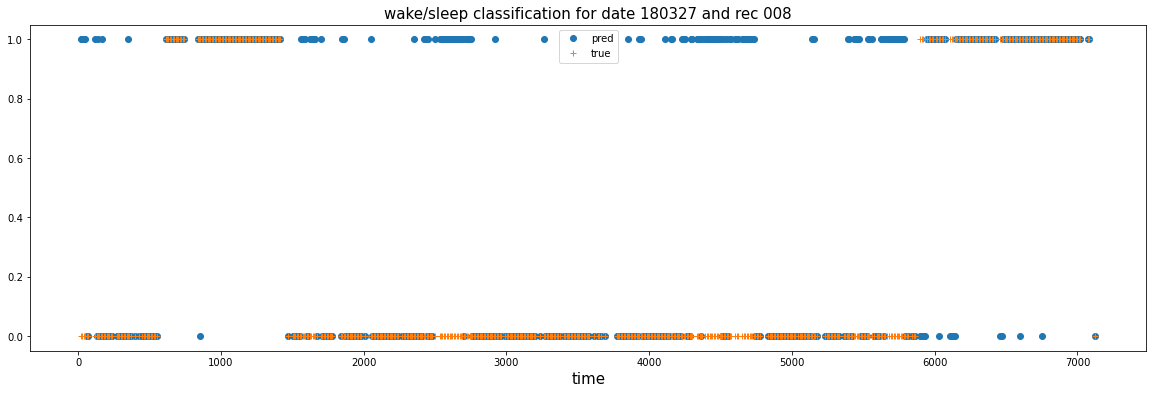

In [12]:
val_loss, val_acc, val_preds, val_preds_probs, val_labels, val_dates, val_recs, val_times, cases_wrong_val = evaluate(model, optimizer, val_loader, alpha=alpha, model_type=model_type, loss_type=loss_type, reg_type=reg_type, collect_result=True, device=device)
print('val loss:{}, val accuracy:{}, val percentage postive:{}'.format(val_loss, val_acc, np.mean(np.concatenate(val_labels))))
plot_pred_vs_true(val_preds, val_labels, val_dates, val_recs, val_times, date_1='180327')

test loss:0.10951589792966843, test accuracy:0.9724556962025317, test percentage postive:0.5


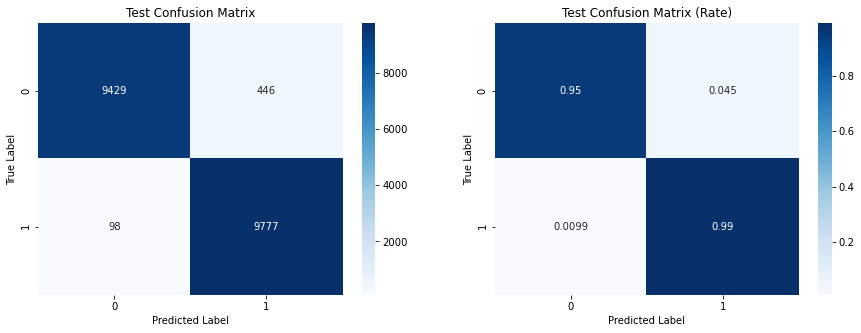

In [15]:
model = LSTM().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
model.load_state_dict(torch.load('{}/{}_CH{}_LOSS{}_REG{}{}_EPOCH{}_REDUCEsum.pt'.format(save_path, model_type, CH, loss_type, reg_type, alpha, num_epochs-1)))


train_loss, train_acc, train_preds, train_preds_probs, train_labels, _, _, _, cases_wrong_train = evaluate(model, optimizer, train_loader, alpha=alpha, model_type=model_type, loss_type=loss_type, reg_type=reg_type, collect_result=True, device=device)
print('test loss:{}, test accuracy:{}, test percentage postive:{}'.format(train_loss, train_acc, np.mean(np.concatenate(train_labels))))
plot_confusion(train_preds, train_labels)